# PNN Example

Example of a network that outputs the mean and variance of a Gaussian distribution.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset

from deep_uq_baselines.models.pnn import PNN
from deep_uq_baselines.util.synthetic_data import create_1d_data

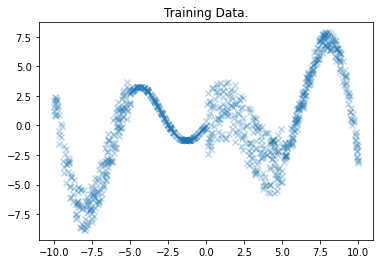

In [2]:
"""Assemble the datasets."""
# Generate synthetic data.
np_data, dataloaders = {}, {}
for data_type, amt in [('Train', 900), ('Validation', 100), ('Test', 200)]:
    xpts, ypts = create_1d_data(amt)
    np_data[data_type] = (xpts, ypts)
    dataloader = DataLoader(
        TensorDataset(
            torch.Tensor(xpts).reshape(-1, 1),
            torch.Tensor(ypts).reshape(-1, 1),
        ),
        batch_size=256,
        shuffle=True,
    )
    dataloaders[data_type] = dataloader
# Visualize the training data.
plt.scatter(np_data['Train'][0], np_data['Train'][1], marker='x', alpha=0.3)
plt.title('Training Data.')
plt.show()

In [3]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=1,
    output_dim=1,
    encoder_hidden_sizes=[64, 64],
    encoder_output_dim=64,
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
)

In [4]:
"""Train the model with a pytorch-lightning trainer."""
trainer = pl.Trainer(max_epochs=1000, check_val_every_n_epoch=50, progress_bar_refresh_rate=0)
trainer.fit(pnn, dataloaders['Train'], dataloaders['Validation'])
# Get the test output.
test_results = trainer.test(pnn, dataloaders['Test'])

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr1/local/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:597: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name        | Type | Params
-------------------------------------
0 | encoder     | MLP  | 8.4 K 
1 | mean_head   | MLP  | 65    
2 | logvar_head | MLP  | 65    
-------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)
/usr1/local/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to tu

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': -0.807502806186676}
--------------------------------------------------------------------------------


/usr1/local/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:349: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  f'Your {mode}_dataloader has `shuffle=True`, it is best practice to turn'
/usr1/local/anaconda3/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


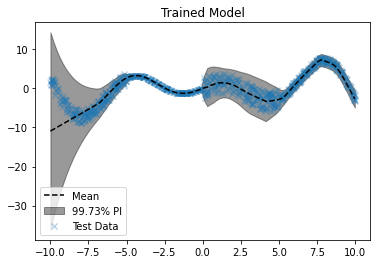

In [5]:
"""Visualize the output along with the test set."""
grid_x = np.linspace(-10, 10, 100)
mean, std = pnn.get_mean_and_standard_deviation(grid_x.reshape(-1, 1))
mean = mean.flatten()
std = std.flatten()
plt.plot(grid_x, mean.flatten(), ls='--', color='black', label='Mean')
plt.fill_between(grid_x, mean - 3 * std, mean + 3 * std, alpha=0.4, color='black', label='99.73% PI')
plt.scatter(np_data['Train'][0], np_data['Train'][1], marker='x', alpha=0.3, label='Test Data')
plt.title('Trained Model')
plt.legend()
plt.show()